In [63]:
import data_handler
import machine_learning as ml
import cost_benefit as cb

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn
from sklearn import linear_model as linear
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from tabulate import tabulate

# These are notebook magix that reloads a function each time, so if I make a change in a .py file, it is automatically reloaded.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## YOU NEED TO FIRST RUN THE TWO LAST CELLS. I HID THEM THERE SO THAT THEY DON'T USE SO MUCH SPACE.

In [43]:
def ohlson_data(year, column_names):
    x_train, x_test, y_train, y_test = data_handler.load_data(year)
    n = y_train.size
    x_train.columns = column_names
    x_test.columns = column_names

    # Ohlson use a dummy if liabilites are greater than assets
    x_train['liabilites > assets'] = (x_train[X02] > 1)*1.0
    x_test['liabilites > assets'] = (x_test[X02] > 1)*1.0
    X65 = ['liabilites > assets']

    # Try to replicate the variables as closely as possible,
    # some of the variables are inverted, but that should not affect
    # the predictability, only the sign of the coefficient.
    ohlson_var = X29 + X02 + X03 + X04 + X65 + X01 + X41 + X21
    x_ohlson_train = x_train[ohlson_var]
    x_ohlson_test = x_test[ohlson_var]
    return x_ohlson_train, x_ohlson_test, y_train, y_test
x_train, x_test, y_train, y_test = ohlson_data(5, column_names)

In [75]:
# Need to create a fake class, since validate model expects a grid search results.
class Object(object):
    pass
logit = Object()
logit.best_estimator_ = linear.LogisticRegression(penalty='none', max_iter=1000)
best_ohlson = ml.validate_model(logit, (x_train, y_train), (x_test, y_test)) ;
cb.cost_benefit_analysis(best_ohlson, (x_test, y_test))
cb.latex_printout(best_ohlson, (x_test, y_test))

Confusion matrix from a LogisticRegression, with test-score of 0.061 and train-score of 0.069 

                Non-Bankrupt    Bankrupt
------------  --------------  ----------
Non-Bankrupt            1095           5
Bankrupt                  79           3
\begin{tabular}{lrr}
\hline
              &   Non-Bankrupt &   Bankrupt \\
\hline
 Non-Bankrupt &           1095 &          5 \\
 Bankrupt     &             79 &          3 \\
\hline
\end{tabular}


# Elastic net

In [2]:
# Load data set
x_train, x_test, y_train, y_test = data_handler.load_data(5, out_frame=False)

Machine learning estimator: LogisticRegression(penalty='elasticnet', solver='saga')

Specification                                                mean score    cf - 5%    cf - 95%
---------------------------------------------------------  ------------  ---------  ----------
{'C': 0.01, 'l1_ratio': 0.0}                                      0.049      0.014       0.084
{'C': 0.01, 'l1_ratio': 0.1111111111111111}                       0.034      0.022       0.045
{'C': 0.01, 'l1_ratio': 0.2222222222222222}                       0.027      0.016       0.039
{'C': 0.01, 'l1_ratio': 0.3333333333333333}                       0.024      0.010       0.039
{'C': 0.01, 'l1_ratio': 0.4444444444444444}                       0.021     -0.002       0.045
{'C': 0.01, 'l1_ratio': 0.5555555555555556}                       0.021     -0.002       0.045
{'C': 0.01, 'l1_ratio': 0.6666666666666666}                       0.021     -0.002       0.045
{'C': 0.01, 'l1_ratio': 0.7777777777777777}                 

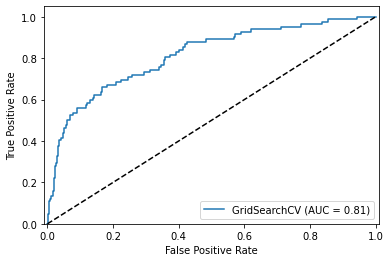

Confusion matrix from a LogisticRegression, with test-score of 0.061 and train-score of 0.092 

                Non-Bankrupt    Bankrupt
------------  --------------  ----------
Non-Bankrupt            1093           7
Bankrupt                  73           9


In [77]:
parameters = {
    'C': np.linspace(0.01, 10, 10), 'l1_ratio': np.linspace(0, 1, 10)
}
logit_elastic_net = linear.LogisticRegression(
    penalty='elasticnet', 
    solver='saga',
    max_iter=100
)
grid_result = ml.search_hyperparameters(
    logit_elastic_net, 
    parameters, 
    (x_train, y_train), 
    scoring='recall', 
    refit=True
)
ml.grid_cv_report(grid_result, x_test, y_test) ;

# Then get the best model given the best hyperparameters
grid_result.best_estimator_.max_iter = 1000  # I increase the iteration in the validation. It is only 100 in the grid search.
best_model = ml.validate_model(grid_result, (x_train, y_train), (x_test, y_test)) ;

In [80]:
cost_benefit_analysis(best_model, (x_test, y_test))
cb.latex_printout(best_model, (x_test, y_test))

\begin{tabular}{lrr}
\hline
              &   Non-Bankrupt &   Bankrupt \\
\hline
 Non-Bankrupt &           1093 &          7 \\
 Bankrupt     &             73 &          9 \\
\hline
\end{tabular}


In [35]:
# This is a way to display the coefficients that are the greatest predictors.
# Not currently used, but saved in case we need it.
np.flip(np.argsort(np.abs(grid_result.best_estimator_.coef_)) + 1)

array([[ 1,  2, 64,  3,  4, 63, 62, 61,  5,  6, 60, 59,  7,  8,  9, 10,
        11, 12, 13, 58, 57, 14, 15, 56, 55, 54, 53, 16, 17, 18, 52, 19,
        20, 21, 22, 23, 24, 51, 25, 26, 50, 49, 27, 28, 29, 30, 48, 47,
        46, 45, 31, 32, 33, 34, 35, 44, 36, 37, 38, 43, 42, 39, 40, 41]])

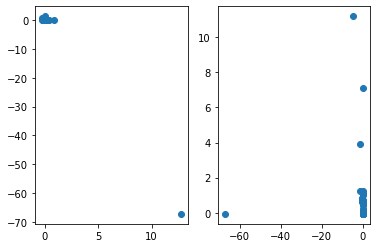

In [40]:
# This is to plot decision probabilites, but I can see that outliers seem to make it quite unclear.
# Look at removing outliers before continuing on this.
# Look at https://scikit-learn.org/stable/auto_examples/classification/plot_classification_probability.html

y_pred = grid_result.best_estimator_.predict(x_train)

fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
idx = (y_pred == 0)
ax0.scatter(x_train[idx, 0], x_train[idx, 1])

idx = (y_pred == 1)
ax1.scatter(x_train[idx, 0], x_train[idx, 1], marker='o', c='w', edgecolor='k')

# Regression Tree

In [36]:
# These are the optimal parameters that I have found, thorough some itterative process.
#max_depth > 3. # We have a lot of features, so it is maybe a good idea to have a ok depth
min_samples_split = [0.005]  # More optimal can be found around 0.003, but I choose this in order to not overfit
min_samples_leaf = [0.005]  # More optimal can be found around 0.007.
learning_rate = [0.9]  # Optimal at 0.92
max_depth = [8]

In [59]:
GBC_parameters = {
    "learning_rate": learning_rate,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "max_depth":max_depth,
    # "max_features": ['sqrt'] # Improves runtime, can be removed after optimal parameters found?
    "subsample":[0.8, 0.85, 0.9, 0.95, 1.0],
}

In [60]:
gradient_boost = GradientBoostingClassifier(
    min_weight_fraction_leaf=0.0,
    min_impurity_decrease=1e-07,
    n_estimators = 100,
    verbose=0,
    warm_start=False
)
grid_result = ml.search_hyperparameters(
    gradient_boost, 
    GBC_parameters, 
    (x_train, y_train), 
    scoring='recall', 
    refit=True,
    n_jobs=4
)

Machine learning estimator: GradientBoostingClassifier(min_impurity_decrease=1e-07)

Specification                                                                                                       mean score    cf - 5%    cf - 95%
----------------------------------------------------------------------------------------------------------------  ------------  ---------  ----------
{'learning_rate': 0.9, 'max_depth': 8, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'subsample': 0.8}          0.491      0.368       0.613
{'learning_rate': 0.9, 'max_depth': 8, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'subsample': 0.85}         0.488      0.290       0.686
{'learning_rate': 0.9, 'max_depth': 8, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'subsample': 0.9}          0.540      0.428       0.651
{'learning_rate': 0.9, 'max_depth': 8, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'subsample': 0.95}         0.588      0.473       0.704
{'learning_rate

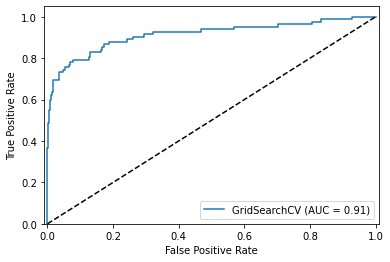

Confusion matrix from a GradientBoostingClassifier, with test-score of 0.591 and train-score of 1.000 

                Non-Bankrupt    Bankrupt
------------  --------------  ----------
Non-Bankrupt            1079          21
Bankrupt                  38          44


In [61]:

# Print a nice report of the results.
ml.grid_cv_report(grid_result, x_test, y_test)
# Then get the best model given the best hyperparameters
best_model = ml.validate_model(grid_result, (x_train, y_train), (x_test, y_test)) ;

In [62]:
print(cb.cost_benefit_analysis(best_model, (x_test, y_test)))
cb.latex_printout(best_model, (x_test, y_test))

(68.70542424921135, 4.518070446047869, 7.530117410079781)
\begin{tabular}{lrr}
\hline
              &   Non-Bankrupt &   Bankrupt \\
\hline
 Non-Bankrupt &           1079 &         21 \\
 Bankrupt     &             38 &         44 \\
\hline
\end{tabular}


In [3]:
gradient_boost = GradientBoostingClassifier(
    loss='deviance',
    learning_rate=0.1, n_estimators=100,
    subsample=1.0, criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3, min_impurity_split=1e-07,
    #init=Null, random_state=Null, max_features=Null,
    verbose=0, #max_leaf_nodes=Null,
    warm_start=False #, presort='auto'
)

ml.validate_model(gradient_boost, (x_train, y_train), (x_test, y_test)) ;

AttributeError: 'GradientBoostingClassifier' object has no attribute 'best_estimator_'

Neural Networks

In [70]:
np.arange(1, 7)

array([1, 2, 3, 4, 5, 6])

In [76]:
MLPC_parameters = {
    'hidden_layer_sizes': np.arange(10, 101, 10),
    'alpha': np.linspace(0, 10, 10)
}

In [77]:
nn = MLPClassifier(
    solver='lbfgs',
    random_state=42,
    warm_start=False
)
nn_grid_result = ml.search_hyperparameters(
    nn, 
    MLPC_parameters, 
    (x_train, y_train), 
    scoring='recall', 
    refit=True,
    n_jobs=4
)

Machine learning estimator: MLPClassifier(random_state=42, solver='lbfgs')

Specification                                               mean score    cf - 5%    cf - 95%
--------------------------------------------------------  ------------  ---------  ----------
{'alpha': 0.0, 'hidden_layer_sizes': 10}                         0.384      0.266       0.503
{'alpha': 0.0, 'hidden_layer_sizes': 20}                         0.454      0.393       0.516
{'alpha': 0.0, 'hidden_layer_sizes': 30}                         0.409      0.316       0.501
{'alpha': 0.0, 'hidden_layer_sizes': 40}                         0.430      0.326       0.534
{'alpha': 0.0, 'hidden_layer_sizes': 50}                         0.445      0.365       0.525
{'alpha': 0.0, 'hidden_layer_sizes': 60}                         0.460      0.407       0.514
{'alpha': 0.0, 'hidden_layer_sizes': 70}                         0.458      0.336       0.579
{'alpha': 0.0, 'hidden_layer_sizes': 80}                         0.476      0.

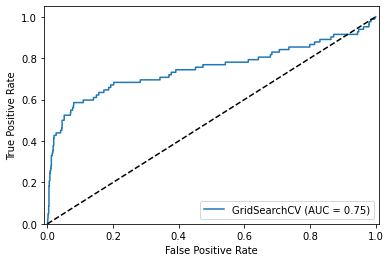

Confusion matrix from a MLPClassifier, with test-score of 0.470 and train-score of 0.908 

                Non-Bankrupt    Bankrupt
------------  --------------  ----------
Non-Bankrupt            1067          33
Bankrupt                  44          38
(68.70542424921135, 4.045494874328017, 6.742491457213362)
\begin{tabular}{lrr}
\hline
              &   Non-Bankrupt &   Bankrupt \\
\hline
 Non-Bankrupt &           1067 &         33 \\
 Bankrupt     &             44 &         38 \\
\hline
\end{tabular}


In [78]:
# Print a nice report of the results.
ml.grid_cv_report(nn_grid_result, x_test, y_test)
# Then get the best model given the best hyperparameters
nn_best_model = ml.validate_model(nn_grid_result, (x_train, y_train), (x_test, y_test)) ;
print(cb.cost_benefit_analysis(nn_best_model, (x_test, y_test)))
cb.latex_printout(nn_best_model, (x_test, y_test))

In [40]:
column_names = ['net profit / total assets','total liabilities / total assets','working capital / total assets','current assets / short-term liabilities','[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365','retained earnings / total assets','EBIT / total assets','book value of equity / total liabilities','sales / total assets','equity / total assets','(gross profit + extraordinary items + financial expenses) / total assets','gross profit / short-term liabilities','(gross profit + depreciation) / sales','(gross profit + interest) / total assets','(total liabilities * 365) / (gross profit + depreciation)','(gross profit + depreciation) / total liabilities','total assets / total liabilities','gross profit / total assets','gross profit / sales','(inventory * 365) / sales','sales (n) / sales (n-1)','profit on operating activities / total assets','net profit / sales','gross profit (in 3 years) / total assets','(equity - share capital) / total assets','(net profit + depreciation) / total liabilities','profit on operating activities / financial expenses','working capital / fixed assets','logarithm of total assets','(total liabilities - cash) / sales','(gross profit + interest) / sales','(current liabilities * 365) / cost of products sold','operating expenses / short-term liabilities','operating expenses / total liabilities','profit on sales / total assets','total sales / total assets','(current assets - inventories) / long-term liabilities','constant capital / total assets','profit on sales / sales','(current assets - inventory - receivables) / short-term liabilities','total liabilities / ((profit on operating activities + depreciation) * (12/365))','profit on operating activities / sales','rotation receivables + inventory turnover in days','(receivables * 365) / sales','net profit / inventory','(current assets - inventory) / short-term liabilities','(inventory * 365) / cost of products sold','EBITDA (profit on operating activities - depreciation) / total assets','EBITDA (profit on operating activities - depreciation) / sales','current assets / total liabilities','short-term liabilities / total assets','(short-term liabilities * 365) / cost of products sold)','equity / fixed assets','constant capital / fixed assets','working capital','(sales - cost of products sold) / sales','(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)','total costs /total sales','long-term liabilities / equity','sales / inventory','sales / receivables','(short-term liabilities *365) / sales','sales / short-term liabilities','sales / fixed assets']

In [42]:
X01 =  ['net profit / total assets']
X02 =  ['total liabilities / total assets']
X03 =  ['working capital / total assets']
X04 =  ['current assets / short-term liabilities']
X05 =  ['[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365']
X06 =  ['retained earnings / total assets']
X07 =  ['EBIT / total assets']
X08 =  ['book value of equity / total liabilities']
X09 =  ['sales / total assets']
X10 =  ['equity / total assets']
X11 =  ['(gross profit + extraordinary items + financial expenses) / total assets']
X12 =  ['gross profit / short-term liabilities']
X13 =  ['(gross profit + depreciation) / sales']
X14 =  ['(gross profit + interest) / total assets']
X15 =  ['(total liabilities * 365) / (gross profit + depreciation)']
X16 =  ['(gross profit + depreciation) / total liabilities']
X17 =  ['total assets / total liabilities']
X18 =  ['gross profit / total assets']
X19 =  ['gross profit / sales']
X20 =  ['(inventory * 365) / sales']
X21 =  ['sales (n) / sales (n-1)']
X22 =  ['profit on operating activities / total assets']
X23 =  ['net profit / sales']
X24 =  ['gross profit (in 3 years) / total assets']
X25 =  ['(equity - share capital) / total assets']
X26 =  ['(net profit + depreciation) / total liabilities']
X27 =  ['profit on operating activities / financial expenses']
X28 =  ['working capital / fixed assets']
X29 =  ['logarithm of total assets']
X30 =  ['(total liabilities - cash) / sales']
X31 =  ['(gross profit + interest) / sales']
X32 =  ['(current liabilities * 365) / cost of products sold']
X33 =  ['operating expenses / short-term liabilities']
X34 =  ['operating expenses / total liabilities']
X35 =  ['profit on sales / total assets']
X36 =  ['total sales / total assets']
X37 =  ['(current assets - inventories) / long-term liabilities']
X38 =  ['constant capital / total assets']
X39 =  ['profit on sales / sales']
X40 =  ['(current assets - inventory - receivables) / short-term liabilities']
X41 =  ['total liabilities / ((profit on operating activities + depreciation) * (12/365))']
X42 =  ['profit on operating activities / sales']
X43 =  ['rotation receivables + inventory turnover in days']
X44 =  ['(receivables * 365) / sales']
X45 =  ['net profit / inventory']
X46 =  ['(current assets - inventory) / short-term liabilities']
X47 =  ['(inventory * 365) / cost of products sold']
X48 =  ['EBITDA (profit on operating activities - depreciation) / total assets']
X49 =  ['EBITDA (profit on operating activities - depreciation) / sales']
X50 =  ['current assets / total liabilities']
X51 =  ['short-term liabilities / total assets']
X52 =  ['(short-term liabilities * 365) / cost of products sold)']
X53 =  ['equity / fixed assets']
X54 =  ['constant capital / fixed assets']
X55 =  ['working capital']
X56 =  ['(sales - cost of products sold) / sales']
X57 =  ['(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)']
X58 =  ['total costs /total sales']
X59 =  ['long-term liabilities / equity']
X60 =  ['sales / inventory']
X61 =  ['sales / receivables']
X62 =  ['(short-term liabilities *365) / sales']
X63 =  ['sales / short-term liabilities']
X64 =  ['sales / fixed assets']

In [6]:
# Decided to drop looping over scores. I think maybe it is best to only use recall.
def loop_over_scores(
        func, parameters, x_train, y_train, scorer_list
    ):
    # Loop over different scorers, like recall, accuracy, etc.
    # Use these different scorers to optimize the hyperparameters
    # for the given ml algorithm, and then pass it to the 
    # grid_cv_reporter to get a nice overview of the results.
    for scorer in scorer_list:
        grid_result = ml.search_hyperparameters(
            func, 
            parameters, 
            (x_train, y_train), 
            scoring=scorer, 
            refit=True
        )
        print(f'Results using {scorer} scorer:')
        ml.grid_cv_report(grid_result, x_test, y_test)
        print('-'*80)
        print()
    return grid_result